# Baseline Predictions for teacher churn 

A baseline prediction for teacher churn rates using Random Forest with basic feature selection. 

## Include libraries and helper functions

Load dependencies and functions

In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import LogisticRegression as LR
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, average_precision_score

# Inputs
source_csv = '/home/andris/GitHub/data/churn_prediction/teacher_time_series.csv'

In [301]:
def prepare_df(df,date_feature, group_array,start_date,end_date):

    # Convert to datetime format
    df[date_feature] = pd.to_datetime(df[date_feature])

    # Select data from dates according to start_date and end_date
    df = df[df[date_feature]>= pd.to_datetime(start_date)]
    df = df[df[date_feature]<= pd.to_datetime(end_date)]

    # Group according to categories
    df_grp = df.groupby(group_array).count();

    # Unpack the indices into columns
    df_grp = df_grp.xs(date_feature, axis=1, drop_level=True)
    df_grp = df_grp.unstack().fillna(0)
  
    # Return the dataframe
    return df_grp

def prepare_time_series(df, month_array, type_operation, groupby_feature = 'user_id'):
    
    # If we want to append each month as a seperate feature 
    if type_operation == 'append':
        
        # Find the months of interest
        df_new = df[df.index.get_level_values(1).isin(month_array)].unstack().fillna(0)
        
        # Name new columns
        new_cols = [str(item[0]) + '_' + str(int(item[1])) for item in df_new.columns]
        
        # Drop level and rename
        df_new.columns = df_new.columns.droplevel(0)
        df_new.columns = new_cols
    
    # If we want to sum the values of each feature for every month
    elif type_operation == 'sum':
        df_new = df[df.index.get_level_values(1).isin(month_array)]
        df_new = df_new.reset_index().groupby(groupby_feature).sum()
    
    return df_new

## Load data and manipulate

In [302]:
# Load the dataframe 
df = pd.read_csv(source_csv)

# Grab the year and month of teacher registration
df_info = df[['user_id','registration_date']].drop_duplicates()
df_info['registration_date'] = pd.to_datetime(df_info['registration_date']) 
df_info['start_month'] = df_info['registration_date'].apply(lambda x:str(x.month))
df_info['start_year'] = df_info['registration_date'].apply(lambda x:x.year)

# Discretise (set time window)
dt = 30*24*3600
df['event_leg'] = np.floor((pd.to_datetime(df['date_created']) - pd.to_datetime(df['registration_date'])).dt.total_seconds()/dt)

# Group and create a new multi index dataframe  

start_date = '2014-08-01'
end_date = '2017-05-01'

df_grp = prepare_df(df,'date_created',['user_id','event_leg','event_type'],start_date,end_date)
df_grp.head()

event_type                                                    add_assig  \
user_id                                            event_leg              
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... -1.0             0.0   
                                                    0.0             0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d...  0.0             0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c...  0.0             0.0   
                                                    1.0             0.0   

event_type                                                    add_custom_assig  \
user_id                                            event_leg                     
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... -1.0                    0.0   
                                                    0.0                    0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d...  0.0                    0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c...  0.0                    0.0   
                                                    1.0                    0.0   

event_type                                                    add_user  \
user_id                                            event_leg             
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... -1.0            0.0   
                                                    0.0            0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d...  0.0            0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c...  0.0            0.0   
                                                    1.0            0.0   

event_type                                                    attempt  \
user_id                                            event_leg            
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... -1.0           4.0   
                                                    0.0           3.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d...  0.0           4.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c...  0.0           8.0   
                                                    1.0           5.0   

event_type                                                    create_group  \
user_id                                            event_leg                 
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... -1.0                0.0   
                                                    0.0                0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d...  0.0                0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c...  0.0                0.0   
                                                    1.0                0.0   

event_type                                                    view_assig_prog  
user_id                                            event_leg                   
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... -1.0                   0.0  
                                                    0.0                   0.0  
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d...  0.0                   0.0  
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c...  0.0                   0.0  
                                                    1.0                   0.0

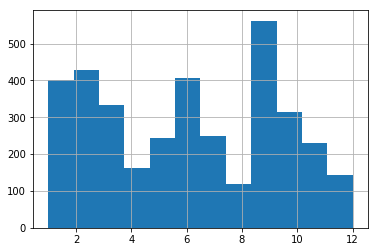

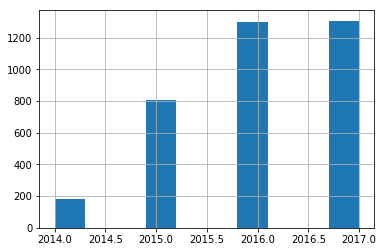

In [303]:
# Plotting the distribution of the start month and the start year

df_info['start_month'].apply(lambda x:int(x)).hist(bins=12)
plt.show()

df_info['start_year'].hist(bins=10)

In [304]:
## Add the events of event_leg -1 to 0

# Change the -1 event to 0
df_new = df_grp[df_grp.index.get_level_values(1)<0].reset_index()
df_new['event_leg'] = 0

# Add the dataframes together
df = df_grp.add(df_new.set_index(['user_id','event_leg']),fill_value=0)

# Removing event_leg = -1
df = df[df.index.get_level_values(1)>= 0]

df.head()

event_type                                                    add_assig  \
user_id                                            event_leg              
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... 0.0              0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d... 0.0              0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0              0.0   
                                                   1.0              0.0   
                                                   4.0              0.0   

event_type                                                    add_custom_assig  \
user_id                                            event_leg                     
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... 0.0                     0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d... 0.0                     0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0                     0.0   
                                                   1.0                     0.0   
                                                   4.0                     0.0   

event_type                                                    add_user  \
user_id                                            event_leg             
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... 0.0             0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d... 0.0             0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0             0.0   
                                                   1.0             0.0   
                                                   4.0             0.0   

event_type                                                    attempt  \
user_id                                            event_leg            
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... 0.0            7.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d... 0.0            4.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0            8.0   
                                                   1.0            5.0   
                                                   4.0           16.0   

event_type                                                    create_group  \
user_id                                            event_leg                 
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... 0.0                 0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d... 0.0                 0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0                 0.0   
                                                   1.0                 0.0   
                                                   4.0                 0.0   

event_type                                                    view_assig_prog  
user_id                                            event_leg                   
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... 0.0                    0.0  
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d... 0.0                    0.0  
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0                    0.0  
                                                   1.0                    0.0  
                                                   4.0                    0.0

In [305]:
last_month = 1;

# Find users that have churned
plot_churn = df.reset_index().groupby('user_id')['event_leg'].max()

# Remove users that have churned before last month
plot_churn = plot_churn[plot_churn.values >= last_month]
df_lm = df.loc[plot_churn.index.values]

# Remove rows all greater than last_month
df_lm = df_lm[df_lm.index.get_level_values(1)<=last_month]
plot_churn =plot_churn.loc[np.unique(df_lm.index.get_level_values(0).values)]

# Label those that churned at last month
label = [1 if item == last_month else 0 for item in plot_churn.values]
df_lm = df_lm.loc[plot_churn.index.values]

# CLean off any nan
df_lm = df_lm.fillna(0)

# Add rows for months that may not exist for a user and set as zero
df_lm = df_lm.unstack(level='event_leg').stack(level='event_leg',dropna=False).fillna(0)

# Display the dataframe
df_lm.head(10)

event_type                                                    add_assig  \
user_id                                            event_leg              
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0              0.0   
                                                   1.0              0.0   
00859f1738f81ed64c8ec0cdc5ebb249b32b4d3896d3996... 0.0              0.0   
                                                   1.0              0.0   
00ab0f1d045f05764b9731a67758d9b401c234ffe7b5de8... 0.0              0.0   
                                                   1.0              1.0   
00d7b52c5e872c5f09ffe70b1c0d5b99b79e4021b5b0c59... 0.0              0.0   
                                                   1.0              0.0   
00ffec02f911cf694e8a2eff69c896bc04929211ce2b6be... 0.0              0.0   
                                                   1.0              0.0   

event_type                                                    add_custom_assig  \
user_id                                            event_leg                     
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0                     0.0   
                                                   1.0                     0.0   
00859f1738f81ed64c8ec0cdc5ebb249b32b4d3896d3996... 0.0                     0.0   
                                                   1.0                     0.0   
00ab0f1d045f05764b9731a67758d9b401c234ffe7b5de8... 0.0                     3.0   
                                                   1.0                     0.0   
00d7b52c5e872c5f09ffe70b1c0d5b99b79e4021b5b0c59... 0.0                     8.0   
                                                   1.0                     0.0   
00ffec02f911cf694e8a2eff69c896bc04929211ce2b6be... 0.0                     0.0   
                                                   1.0                     0.0   

event_type                                                    add_user  \
user_id                                            event_leg             
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0             0.0   
                                                   1.0             0.0   
00859f1738f81ed64c8ec0cdc5ebb249b32b4d3896d3996... 0.0             0.0   
                                                   1.0             0.0   
00ab0f1d045f05764b9731a67758d9b401c234ffe7b5de8... 0.0            10.0   
                                                   1.0             1.0   
00d7b52c5e872c5f09ffe70b1c0d5b99b79e4021b5b0c59... 0.0            23.0   
                                                   1.0             3.0   
00ffec02f911cf694e8a2eff69c896bc04929211ce2b6be... 0.0             0.0   
                                                   1.0             0.0   

event_type                                                    attempt  \
user_id                                            event_leg            
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0            8.0   
                                                   1.0            5.0   
00859f1738f81ed64c8ec0cdc5ebb249b32b4d3896d3996... 0.0            0.0   
                                                   1.0            9.0   
00ab0f1d045f05764b9731a67758d9b401c234ffe7b5de8... 0.0           60.0   
                                                   1.0            0.0   
00d7b52c5e872c5f09ffe70b1c0d5b99b79e4021b5b0c59... 0.0           12.0   
                                                   1.0            0.0   
00ffec02f911cf694e8a2eff69c896bc04929211ce2b6be... 0.0            4.0   
                                                   1.0            0.0   

event_type                                                    create_group  \
user_id                                            event_leg                 
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0                 0.0   
                                                   1.0                 0.0   
00859f1738f81ed64c8ec0cdc5ebb249b32b

In [306]:
# Prepare timeseries
df_lm_new = prepare_time_series(df_lm.groupby(['user_id','event_leg']).sum(),[0,1],'append')

# Add features
df_lm_new = df_lm_new.join(df_info.set_index('user_id')[['start_month','start_year']])

# Get dummies
df_lm_new = pd.get_dummies(df_lm_new)

print(df_lm_new.shape)

df_lm_new.head()


(1208, 25)


,add_assig_0,add_assig_1,add_custom_assig_0,add_custom_assig_1,add_user_0,add_user_1,attempt_0,attempt_1,create_group_0,create_group_1,...,start_month_11,start_month_12,start_month_2,start_month_3,start_month_4,start_month_5,start_month_6,start_month_7,start_month_8,start_month_9
user_id,,,,,,,,,,,,,,,,,,,,,
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726cb140669288a58515b,0.0,0.0,0.0,0.0,0.0,0.0,8.0,5.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
00859f1738f81ed64c8ec0cdc5ebb249b32b4d3896d3996d14b7e53a3094ed80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
00ab0f1d045f05764b9731a67758d9b401c234ffe7b5de85b0764b714db2ba90,0.0,1.0,3.0,0.0,10.0,1.0,60.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
00d7b52c5e872c5f09ffe70b1c0d5b99b79e4021b5b0c592c6f1fe2c5b7b0028,0.0,0.0,8.0,0.0,23.0,3.0,12.0,0.0,2.0,0.0,...,0,0,0,0,0,1,0,0,0,0
00ffec02f911cf694e8a2eff69c896bc04929211ce2b6beba1546c8acc819591,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0


(array([ 1020.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,   188.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

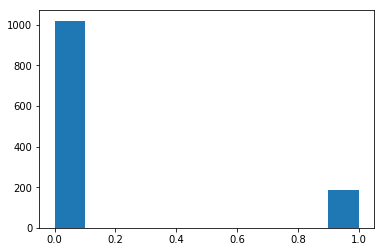

In [307]:
# Check class distribution
plt.hist(label)


(array([ 307.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   56.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

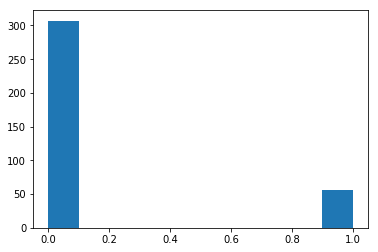

In [308]:
# Fill in any zeros
df_lm_new = df_lm_new.fillna(0)

# Assign data to auxillary variables
X = df_lm_new
y = label

# Storing the keys
store_keys = X.keys()

# Scale the data
scaler = StandardScaler()
X_trf = scaler.fit_transform(X)
X = X_trf

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3, random_state=42)

plt.hist(y_test)

## Machine learning

Comparing results against random predictions.

In [309]:
# Do a test with a Dummy Classifier

clf = DummyClassifier(strategy='constant', constant=1)
clf.fit(X_train,y_train)

# Predict
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

# Evaluate

print(classification_report(y_pred,y_test))

clf = DummyClassifier(strategy='stratified')
clf.fit(X_train,y_train)

# Predict
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

# Evaluate

print(classification_report(y_pred,y_test))



             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.15      0.27       363

avg / total       1.00      0.15      0.27       363

             precision    recall  f1-score   support

          0       0.80      0.84      0.82       294
          1       0.16      0.13      0.14        69

avg / total       0.68      0.71      0.69       363



/home/work/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.15379474727673698

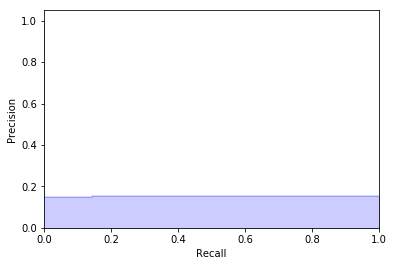

In [310]:
precision, recall, _ = precision_recall_curve(y_test,y_score[:,1])


plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

average_precision_score(y_test,y_score[:,1])

             precision    recall  f1-score   support

          0       0.96      0.89      0.93       332
          1       0.36      0.65      0.46        31

avg / total       0.91      0.87      0.89       363



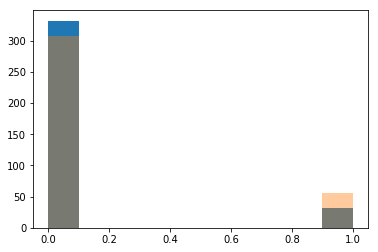

In [311]:
# Classifier
clf = RF(n_estimators=100,random_state=42)
clf.fit(X_train,y_train)

# Predict
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

# Evaluate
plt.hist(y_pred)
plt.hist(y_test,alpha= 0.4)

print(classification_report(y_pred,y_test))


0.54732826944
@ 0.5
True positives: 45
True negatives: 233
False negatives: 11
False positives: 74
Precision is: 0.378151260504
Recall is: 0.803571428571


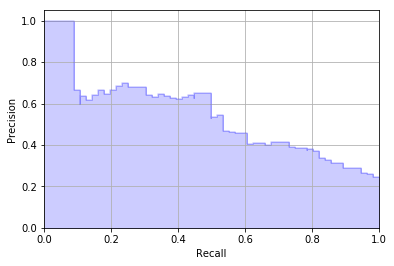

In [312]:
precision, recall, _ = precision_recall_curve(y_test,y_score[:,1])


plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid()

print(average_precision_score(y_test,y_score[:,1]))

def calculate_errors(y_test,y_pred):

    true_pos = 0;
    true_neg = 0
    false_neg = 0;
    false_pos = 0
    for item in range(len(y_test)):

        if y_test[item] == 1:

            if y_test[item] == y_pred[item]:
                true_pos +=1

            else:
                false_neg +=1

        if y_test[item] == 0:

            if y_test[item] == y_pred[item]:
                true_neg +=1

            else:
                false_pos += 1

    print('True positives:',true_pos)
    print('True negatives:',true_neg)
    print('False negatives:',false_neg)
    print('False positives:',false_pos)

    
y_pred2 = [1 if item > 0.2 else 0 for item in y_score[:,1]]

print('@ 0.5')
calculate_errors(y_test,y_pred2)
print('Precision is:',precision_score(y_test,y_pred2))
print('Recall is:',recall_score(y_test,y_pred2))

0.861621684504


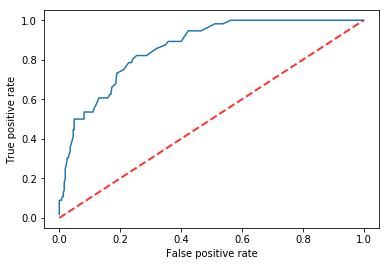

In [313]:

fpr, tpr, thresholds = roc_curve(y_test,y_score[:,1])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

print(roc_auc_score(y_test,y_score[:,1]))



## Feature extraction

Checking the importance of each feature and retraining model.

Standard and with BorutaPy.

In [314]:
# Get the feature importance

# Output feature importance

def return_feature_importance(X,y,keys,n_estimators = 100):

    # Using the random forest classifier, find out what are the main features that predict whether a user is likely to churn or not
    randomForest = RF(n_estimators)
    randomForest.fit(X,y)
    
    importances = randomForest.feature_importances_
    
    indices = np.argsort(importances)[::-1]
    
    # Print the feature ranking
    print("Feature ranking:")
    
    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]),keys[indices[f]])

return_feature_importance(X,y,store_keys)

Feature ranking:
1. feature 12 (0.176523) start_year
2. feature 7 (0.113809) attempt_1
3. feature 6 (0.098454) attempt_0
4. feature 5 (0.067167) add_user_1
5. feature 11 (0.065452) view_assig_prog_1
6. feature 4 (0.065214) add_user_0
7. feature 8 (0.058514) create_group_0
8. feature 10 (0.049370) view_assig_prog_0
9. feature 2 (0.045835) add_custom_assig_0
10. feature 9 (0.040485) create_group_1
11. feature 3 (0.039493) add_custom_assig_1
12. feature 0 (0.023156) add_assig_0
13. feature 18 (0.018706) start_month_3
14. feature 1 (0.016856) add_assig_1
15. feature 24 (0.015640) start_month_9
16. feature 13 (0.015218) start_month_1
17. feature 14 (0.015136) start_month_10
18. feature 15 (0.013869) start_month_11
19. feature 16 (0.012712) start_month_12
20. feature 17 (0.012209) start_month_2
21. feature 21 (0.012099) start_month_6
22. feature 20 (0.008988) start_month_5
23. feature 19 (0.006740) start_month_4
24. feature 22 (0.005744) start_month_7
25. feature 23 (0.002611) start_month_8


In [315]:
# Using the boprutaPy package

from boruta import BorutaPy

rf = RF(n_jobs=-1, class_weight='balanced', max_depth=5)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
feat_selector.fit(X, y)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	3
Tentative: 	8
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	8
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	10 / 100
Confirmed: 	3
Tentative: 	8
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	11 / 100
Confirmed: 	3
Tentative: 	8
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	12 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	13 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	14 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	15 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	16 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	17 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	18 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	19 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	20 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	21 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	22 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	23 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	24 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	25 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	26 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	27 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	28 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	29 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	30 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	31 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	32 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	33 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	34 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	35 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	36 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	37 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	38 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	39 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	40 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	41 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	42 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	43 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	44 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	45 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	46 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	47 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	48 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	49 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	50 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	51 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	52 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	53 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	54 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	55 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	56 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	57 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	58 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	59 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	60 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	61 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	62 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	63 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	64 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	65 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	66 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	67 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	68 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	69 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	70 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	71 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	72 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	73 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	74 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	75 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	76 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	77 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	78 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	79 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	80 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	81 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	82 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	83 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	84 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	85 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	86 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	87 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	88 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	89 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	90 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	91 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	92 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	93 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	94 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	95 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	96 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	97 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	98 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15
Iteration: 	99 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


BorutaPy(alpha=0.05,
     estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=89, n_jobs=-1, oob_score=False,
            random_state=<mtrand.RandomState object at 0x7f89450ca318>,
            verbose=0, warm_start=False),
     max_iter=100, n_estimators='auto', perc=100,
     random_state=<mtrand.RandomState object at 0x7f89450ca318>,
     two_step=True, verbose=2)

In [316]:
# Print the columns that were found to be important
print(df_lm_new.columns[feat_selector.support_])

# Get the rank
print(pd.DataFrame({'name':df_lm_new.columns,'rank':feat_selector.ranking_}).sort_values('rank'))

# Transform X
X_filtered = feat_selector.transform(X)


Index(['add_user_0', 'add_user_1', 'attempt_0', 'attempt_1', 'create_group_0',
       'create_group_1', 'view_assig_prog_1', 'start_year', 'start_month_6'],
      dtype='object')
                  name  rank
12          start_year     1
4           add_user_0     1
5           add_user_1     1
6            attempt_0     1
7            attempt_1     1
8       create_group_0     1
9       create_group_1     1
11   view_assig_prog_1     1
21       start_month_6     1
2   add_custom_assig_0     2
3   add_custom_assig_1     3
10   view_assig_prog_0     4
18       start_month_3     5
1          add_assig_1     6
17       start_month_2     6
0          add_assig_0     8
24       start_month_9     8
22       start_month_7    10
13       start_month_1    11
16      start_month_12    12
14      start_month_10    12
15      start_month_11    14
20       start_month_5    15
23       start_month_8    16
19       start_month_4    17


             precision    recall  f1-score   support

          0       0.94      0.90      0.92       320
          1       0.45      0.58      0.51        43

avg / total       0.88      0.87      0.87       363



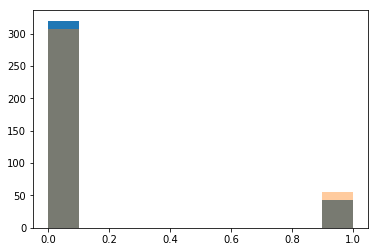

In [317]:
# Let's train and evaluate the model

# Assign
X = X_filtered

# Scale the data
scaler = StandardScaler()
X_trf = scaler.fit_transform(X_filtered)
X = X_trf

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3, random_state=42)

# Classifier
clf = RF(n_estimators=100,random_state=42)
clf.fit(X_train,y_train)

# Predict
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

# Evaluate
plt.hist(y_pred)
plt.hist(y_test,alpha= 0.4)

print(classification_report(y_pred,y_test))


0.58779645764468746

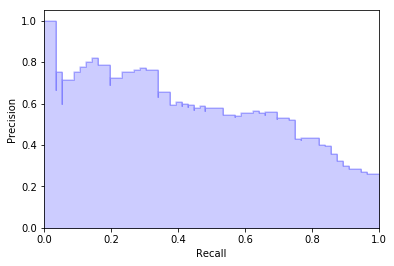

In [318]:
precision, recall, _ = precision_recall_curve(y_test,y_score[:,1])


plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

average_precision_score(y_test,y_score[:,1])
